# Credit Risk Analysis --- Clustering

> Pada notebook ini saya akan memperlihatkan segmentasi-segmentasi pada dataset ini dengan bantuan K-Means, DBSCAN, dan Agglomerative Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import scipy.stats as ss
from sklearn.neighbors import KernelDensity
from scipy.stats import mannwhitneyu, chi2_contingency
from scipy.stats import shapiro

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score,silhouette_score,silhouette_samples 
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

import warnings 
warnings.filterwarnings('ignore')

In [2]:
sns.set_style('whitegrid')

In [3]:
credit = pd.read_csv('credit_clean.csv').drop('Unnamed: 0', axis = 1)

In [4]:
credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age Groups
0,67,male,2,own,little,little,1169,6,radio/TV,good,60+
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,<30
2,49,male,1,own,little,little,2096,12,education,good,40-59
3,45,male,2,free,little,little,7882,42,furniture/equipment,good,40-59
4,53,male,2,free,little,little,4870,24,car,bad,40-59


In [5]:
pd.DataFrame({'dataFeatures' : credit.columns, 'dataType' : credit.dtypes.values, 
              'null' : [credit[i].isna().sum() for i in credit.columns],
              'nullPct' : [((credit[i].isna().sum()/len(credit[i]))*100).round(2) for i in credit.columns],
             'Nunique' : [credit[i].nunique() for i in credit.columns],
             'uniqueSample' : [list(pd.Series(credit[i].unique()).sample(2)) for i in credit.columns]}).reset_index(drop = True)

,dataFeatures,dataType,null,nullPct,Nunique,uniqueSample
0,Age,int64,0,0.0,53,"[30, 66]"
1,Sex,object,0,0.0,2,"[female, male]"
2,Job,int64,0,0.0,4,"[1, 3]"
3,Housing,object,0,0.0,3,"[free, rent]"
4,Saving accounts,object,0,0.0,4,"[rich, little]"
5,Checking account,object,0,0.0,3,"[rich, moderate]"
6,Credit amount,int64,0,0.0,921,"[3965, 2825]"
7,Duration,int64,0,0.0,33,"[26, 39]"
8,Purpose,object,0,0.0,8,"[radio/TV, education]"
9,Risk,object,0,0.0,2,"[bad, good]"


In [6]:
categorical = credit.select_dtypes('object')
numerical = credit.drop(categorical, axis = 1)

# Hypothesis Testing

## Normality Test

In [7]:
shap = []

for i in numerical.columns:
    if shapiro(credit[i])[1] < 0.05:
        shap.append('Reject Null Hypothesis')
    else:
        shap.append('Fail To reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : shap}, index = numerical.columns)

,Hypothesis
Age,Reject Null Hypothesis
Job,Reject Null Hypothesis
Credit amount,Reject Null Hypothesis
Duration,Reject Null Hypothesis


## Significance Test

In [8]:
chi2 = []

for i in categorical.columns:
    if chi2_contingency(pd.crosstab(credit['Risk'], credit[i]))[1] < 0.05:
        chi2.append('Reject Null Hypothesis')
    else:
        chi2.append('Fail To Reject Null Hypothesis')
        
pd.DataFrame({'Hypothesis' : chi2}, index = categorical.columns)

,Hypothesis
Sex,Reject Null Hypothesis
Housing,Reject Null Hypothesis
Saving accounts,Reject Null Hypothesis
Checking account,Reject Null Hypothesis
Purpose,Fail To Reject Null Hypothesis
Risk,Reject Null Hypothesis
Age Groups,Reject Null Hypothesis


In [9]:
mannwhit = []

for i in numerical.columns:
    if mannwhitneyu(credit[credit['Risk'] == 'bad'][i],credit[credit['Risk'] == 'good'][i])[1] < 0.05:
        mannwhit.append('Reject Null Hypothesis')
    else:
        mannwhit.append('Fail To reject Null Hypothesis')

pd.DataFrame({'Hypothesis' : mannwhit}, index = numerical.columns)

,Hypothesis
Age,Reject Null Hypothesis
Job,Fail To reject Null Hypothesis
Credit amount,Reject Null Hypothesis
Duration,Reject Null Hypothesis


# Clustering Analysis

Pada <i>hypothesis testing</i> sebelumnya, telah diperlihatkan bahwa fitur <i>Job</i> tidaklah signifikan. Itu kenapa saya hanya akan menggunakan fitur <i>age, duration</i>, dan <i>credit amount</i>. Clustering yang akan saya gunakan adalah <b>K-Means, Agglomerative Clustering, dan DBSCAN</b>.

In [10]:
dfcluster = credit[['Age','Duration','Credit amount']]
sc = StandardScaler()
X = sc.fit_transform(dfcluster)

## K-Means

### Silhouette Analysis

Saya menggunakan Silhouette analysis untuk menentukan K

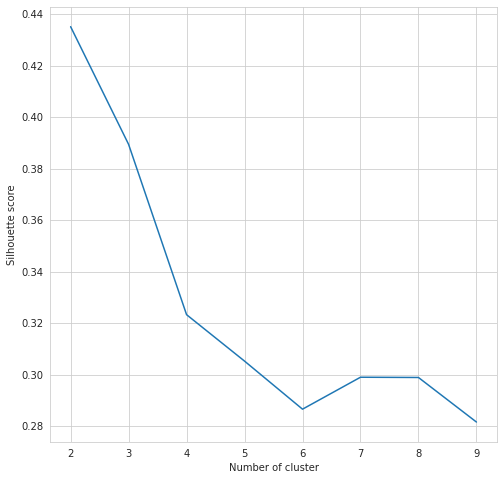

In [11]:
slc = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=10).fit(X)
    clusters = kmeans.labels_
    slc[k] = silhouette_score(X,clusters)
    
plt.figure(figsize=(8,8))
plt.plot(list(slc.keys()), list(slc.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette score")
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.43510203613691784
For n_clusters = 3 The average silhouette_score is : 0.3894237180526776
For n_clusters = 4 The average silhouette_score is : 0.3233042742563264
For n_clusters = 5 The average silhouette_score is : 0.30527712058493955
For n_clusters = 6 The average silhouette_score is : 0.2866133924460227
For n_clusters = 7 The average silhouette_score is : 0.29901690144543047
For n_clusters = 8 The average silhouette_score is : 0.2989181080489886
For n_clusters = 9 The average silhouette_score is : 0.2816223575893109


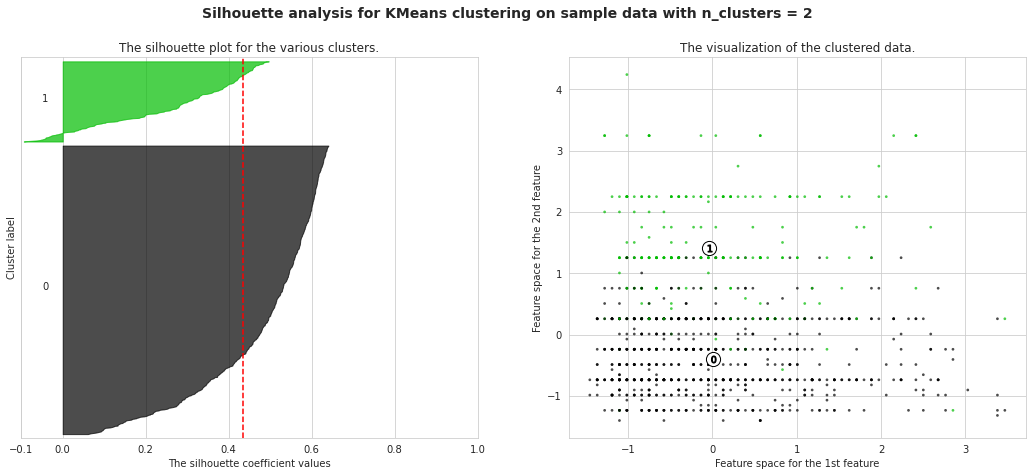

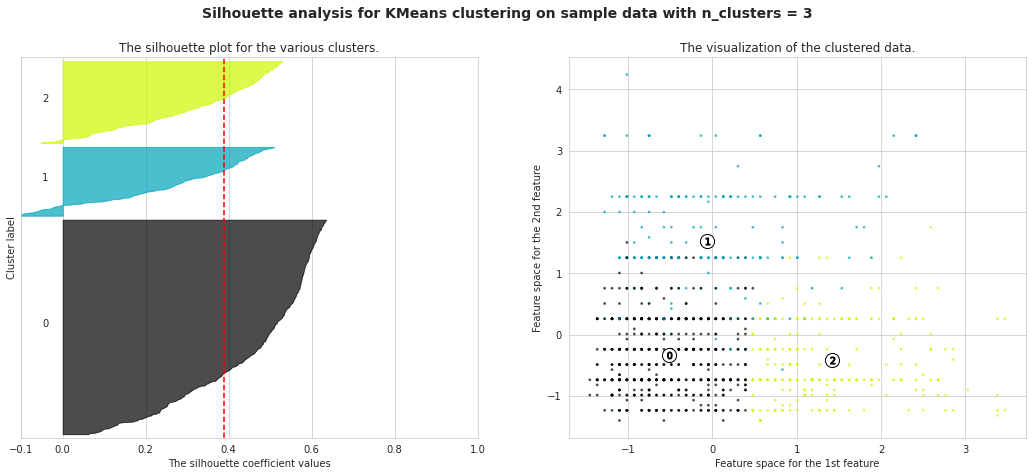

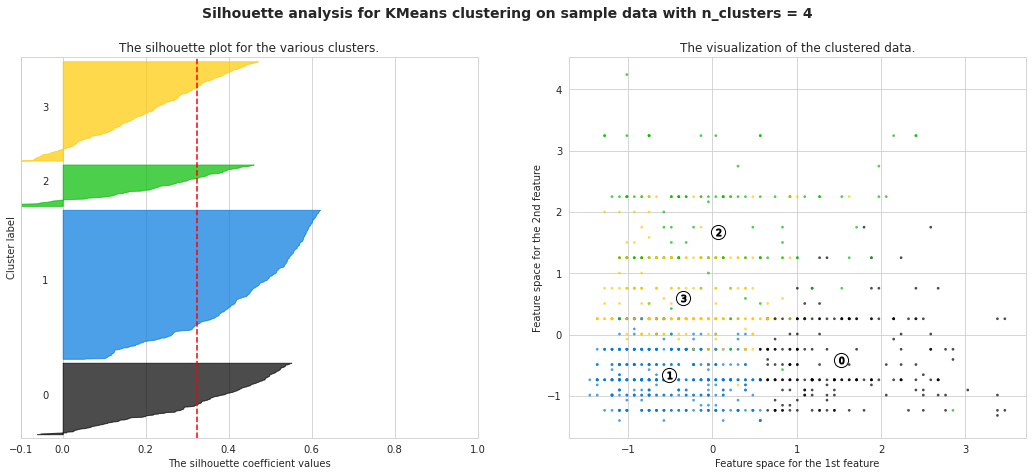

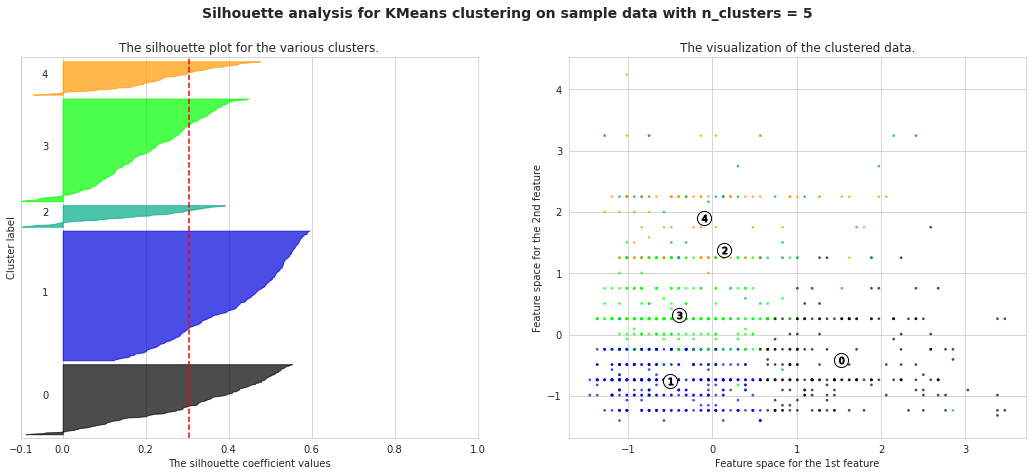

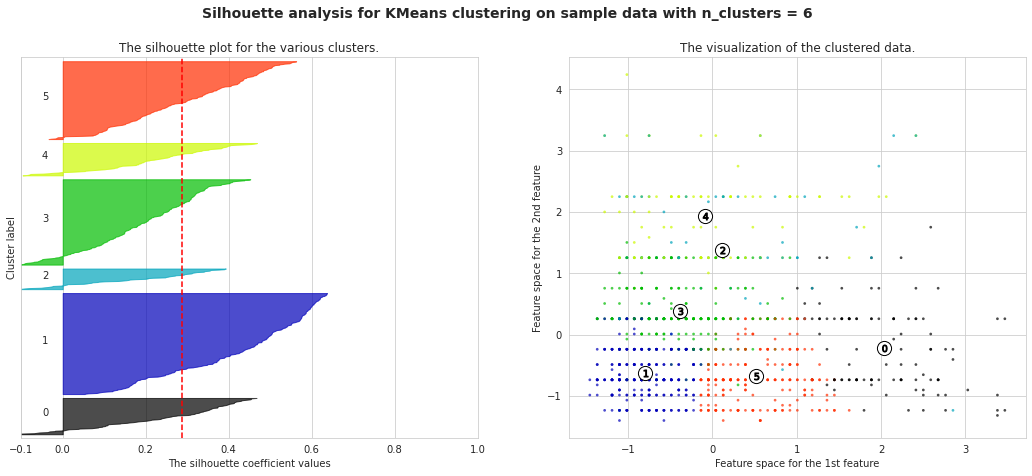

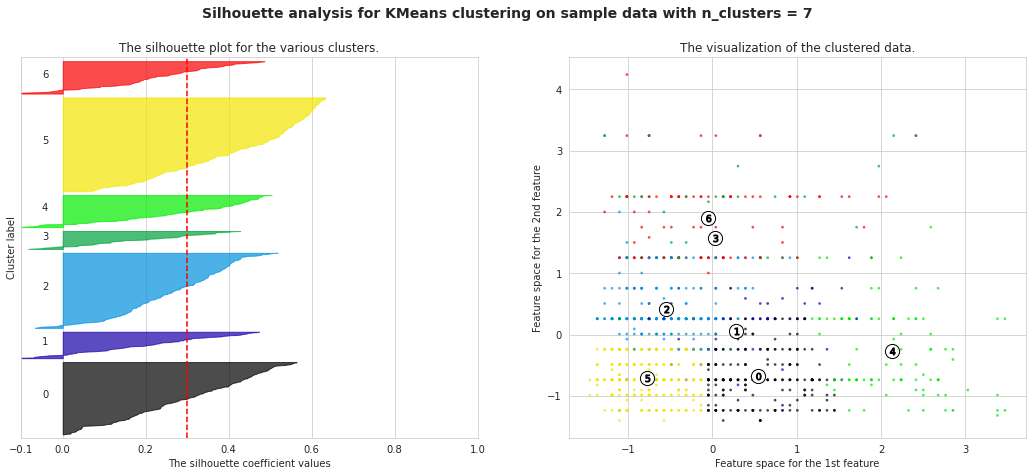

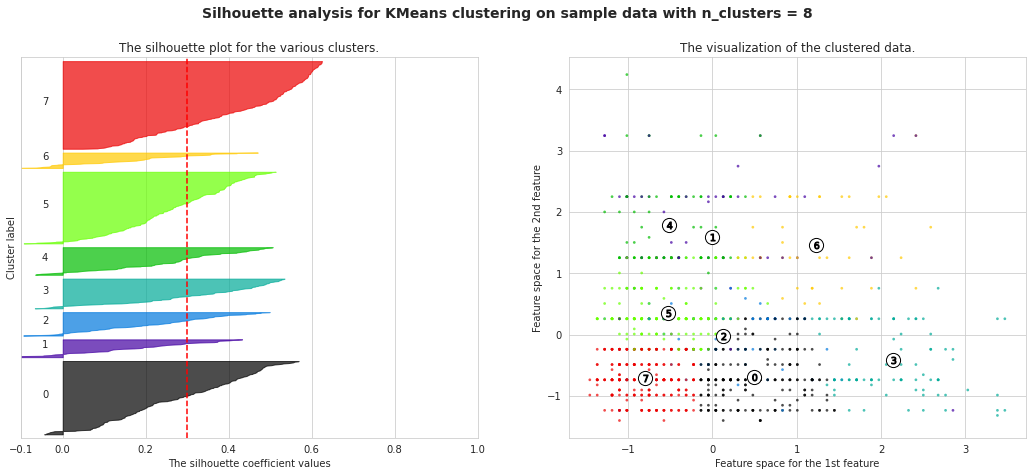

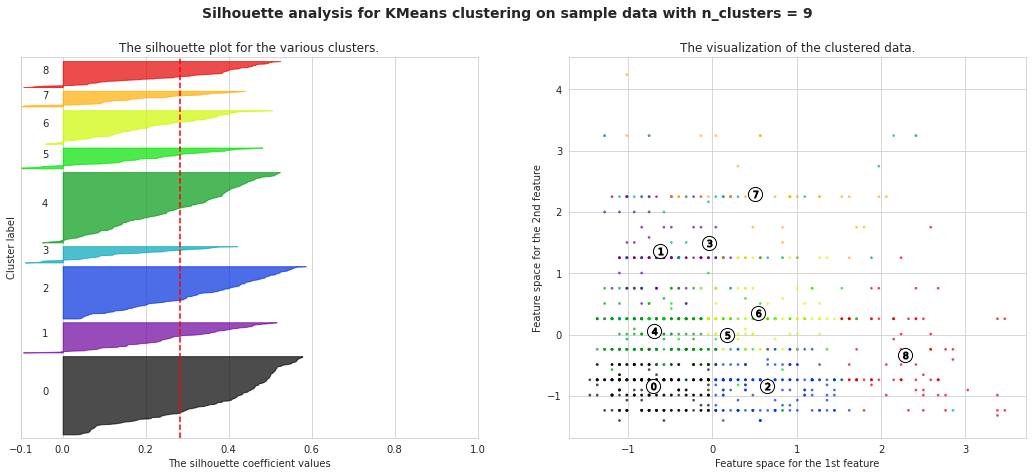

In [12]:
for n_clusters in range(2, 10):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])

    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters,max_iter=1000, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Dari plot di atas menunjukkan bahwa K = 2

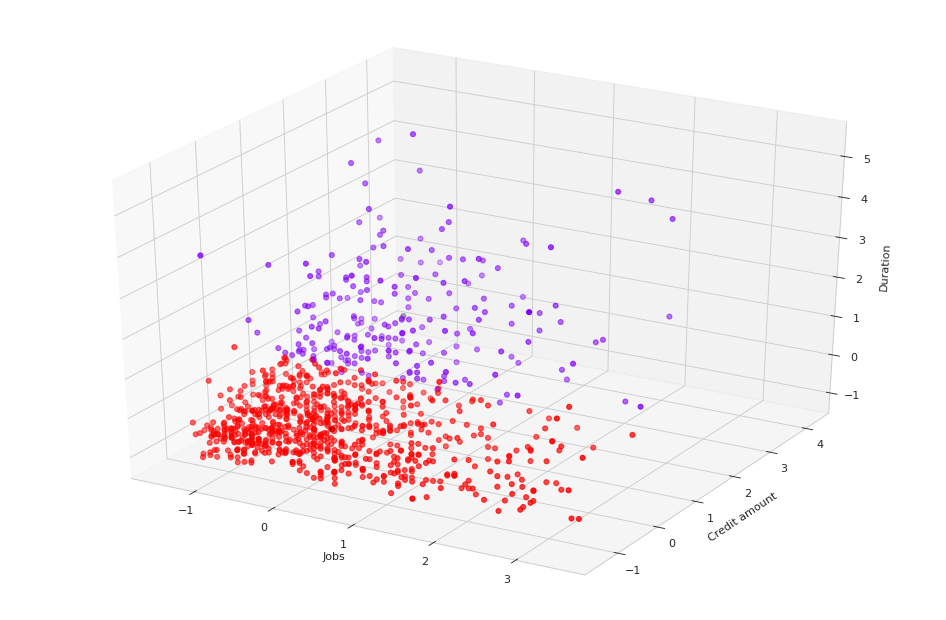

In [13]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
labels = kmeans.labels_


fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

ax.scatter3D(X[:,0], X[:,1], X[:,2], c=kmeans.labels_, cmap='rainbow')
ax.scatter3D(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], c='black')

xLabel = ax.set_xlabel('Jobs', linespacing=3.2)
yLabel = ax.set_ylabel('Credit amount', linespacing=3.1)
zLabel = ax.set_zlabel('Duration', linespacing=3.4)

In [14]:
df_kmeans = dfcluster.assign(Cluster = labels)
groupbyKmeans = df_kmeans.groupby(['Cluster']).mean().round(1) #get the centroid
groupbyKmeans

,Age,Duration,Credit amount
Cluster,,,
0,35.3,37.8,7248.8
1,35.6,16.1,2149.4


Dari K-means terdapat dua kluster dimana: 
* Cluster 0 adalah orang-orang yang punya jumlah kredit yang besar dan berdurasi panjang.
* Cluster 1 adalah orang-orang yang punya jumlah kredit yang sedikit dan berdurasi pendek.

Sebetulnya dari kluster ini bisa dilihat juga rata-rata menyicilnya, orang-orang pada kluster 0 menyicil kredit lebih banyak daripada kluster 1.


# Hierarchical Clustering Dendrogram

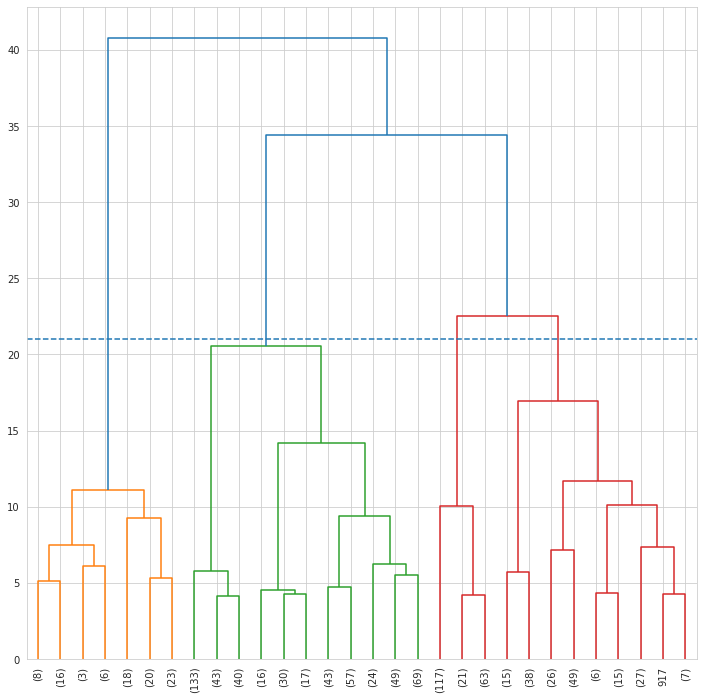

In [15]:
Z = linkage(X, method = 'ward')
plt.figure(figsize = (12,12))
plt.axhline(y = 21, linestyle = '--')
dendrogram(Z, truncate_mode = 'lastp')
plt.xticks(rotation = 90)
plt.show()

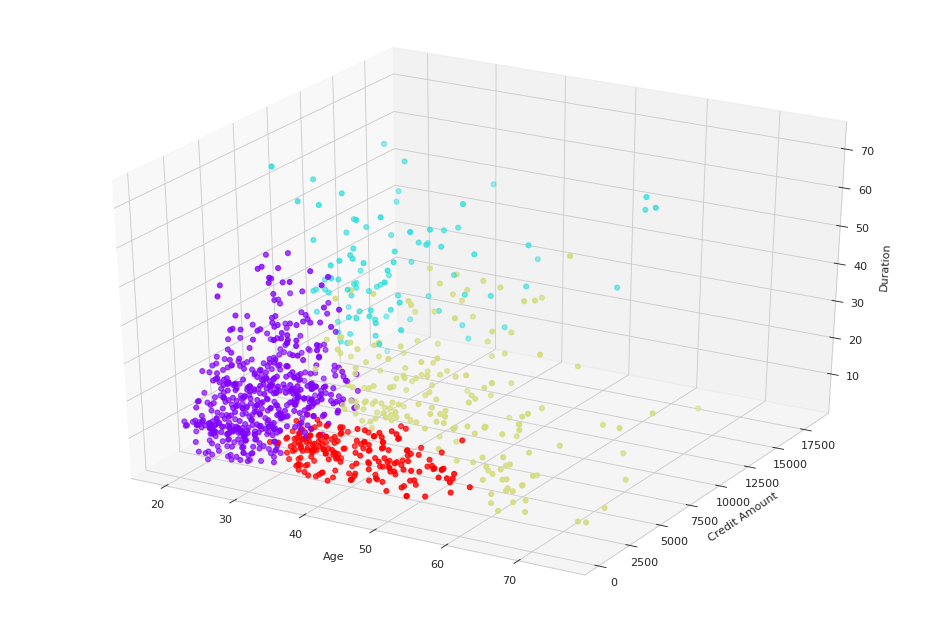

In [16]:
agglo = AgglomerativeClustering(n_clusters=4)
agglo.fit(X)
agglo_labels = agglo.labels_

fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

ax.scatter3D(dfcluster['Age'],dfcluster['Credit amount'],dfcluster['Duration'],c=agglo_labels, cmap='rainbow')

xLabel = ax.set_xlabel('Age', linespacing=3.2)
yLabel = ax.set_ylabel('Credit Amount', linespacing=3.1)
zLabel = ax.set_zlabel('Duration', linespacing=3.4)

In [17]:
df_agglo = dfcluster.assign(Cluster = agglo_labels)
groupbyAgglo = df_agglo.groupby(['Cluster']).mean().round(1) #get the centroid
groupbyAgglo

,Age,Duration,Credit amount
Cluster,,,
0,28.0,20.0,2476.8
1,33.5,41.2,9681.1
2,51.0,24.5,3977.5
3,42.0,10.5,1686.5


Dari Agglomerative Clustering terdapat empat kluster, dimana:

* Cluster 0 adalah orang-orang berumur muda atau bisa dikategorikan (young-adults) dengan jumlah kredit yang sedikit dan berdurasi relatif pendek.

* Cluster 1 adalah orang-orang yang berumur relatif 'tua' dengan jumlah kredit yang lumayan besar dan berdurasi panjang.

* Cluster 2 adalah orang-orang yang bisa dibilang 'tua' dengan jumlah kredit yang relatif sedang dan berdurasi relatif pendek.

* Cluster 3 adalah orang-orang yang juga bisa dibilang 'tua', dengan jumlah kredit yang kecil dan berdurasi pendek.

Menurut saya, agglomerative clustering benar-benar baik dalam melakukan clustering pada dataset ini. Terlihat bahwa hampir semua segmen didapati olehnya. 

# DBSCAN

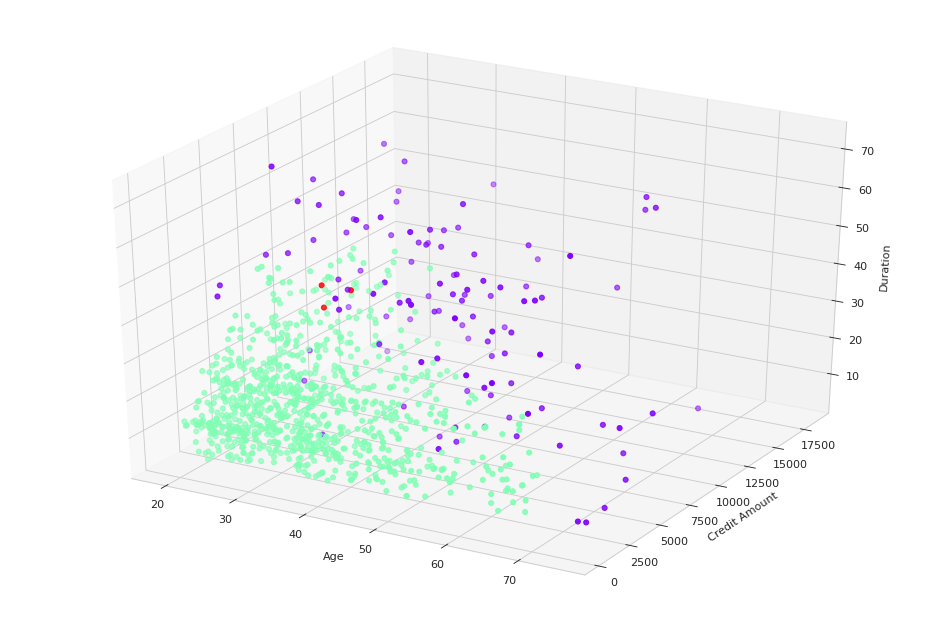

In [18]:
dbscan = DBSCAN()
dbscan.fit(X)
dbscan_labels = dbscan.labels_

fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

ax.scatter3D(dfcluster['Age'],dfcluster['Credit amount'],dfcluster['Duration'],c=dbscan_labels, cmap='rainbow')

xLabel = ax.set_xlabel('Age', linespacing=3.2)
yLabel = ax.set_ylabel('Credit Amount', linespacing=3.1)
zLabel = ax.set_zlabel('Duration', linespacing=3.4)

In [19]:
df_dbscan = dfcluster.assign(Cluster = dbscan_labels)
groupbydbscan = df_dbscan.groupby(['Cluster']).mean().round(1)
groupbydbscan

,Age,Duration,Credit amount
Cluster,,,
-1,44.1,36.7,8227.6
0,34.4,18.8,2629.2
1,35.3,46.0,3907.7


In [20]:
pd.Series(dbscan_labels).value_counts()

 0    883
-1    114
 1      3
dtype: int64

Dari DBSCAN terdapat tiga cluster, dimana:
* Cluster 1 : adalah orang-orang yang berumur cukup tua dengan jumlah kredit relatif sedang tapi berdurasi panjang. Satu hal yang saya senangi dari DBSCAN, mereka juga terkadang dipakai untuk menemukan multivariate outliers. Dan ini bisa dijadikan contoh (bisa jadi contoh baik atau buruk tergantung menurut pemberi pinjaman), karena orang-orang yang berada di kluster ini bisa dibilang agak jarang terjadi. Mengingat jumlah kredit yang sedang tapi berdurasi panjang. Ini bisa dibilang panjang mengingat jumlah kreditnya relatif tidak terlalu banyak. 
* Cluster -1 : adalah orang-orang yang berumur tua dengan jumlah kredit yang relatif besar dan berdurasi relatif panjang. Jumlah di cluster ini tidak terlalu banyak. 
* Cluster 0 : adalah orang-orang yang berumur relatif tua paling mendominasi di dataset ini, orang-orang yang punya kredit sedikit dan berdurasi pendek. 

# Conclusion

Kalau saya ringkas lagi yang di atas, sebetulnya saya paling senang Agglomerative Clustering dan DBSCAN. Mengingat Agglomerative clustering hampir dapat memperlihatkan semua segmen (dari yang muda sampai bisa dibilang tua). Sedangkan DBSCAN dapat memperlihatkan multivariate outliers dan nilai jumlahnya pada DBSCAN juga jadi signifikan, mengingat DBSCAN melihat densitasnya. Rekomendasinya, setelah melihat karakteristik setiap cluster seharusnya bisa dijadikan acuan mana yang kira-kira beresiko dan mana yang tidak. 